# MMDeploy本地部署预测-单张图像

同济子豪兄：https://space.bilibili.com/1900783

## 本代码需在终端本地运行

## 导入工具包

In [13]:
import cv2
import numpy as np
import time
from tqdm import tqdm

from mmdeploy_runtime import Detector
from mmdeploy_runtime import PoseDetector

import matplotlib.pyplot as plt
%matplotlib inline

## 载入图像

In [14]:
img_path = 'mmpose/data/test_triangle/triangle_3.jpg'

In [15]:
img_bgr = cv2.imread(img_path)

## 载入模型

In [16]:
# 目标检测模型目录
detect = 'rtmdet2onnx'

# 关键点检测模型目录
pose = 'rtmpose2onnx'

# 计算设备
device = 'cpu'
# device = 'cuda'

bbox_detector = Detector(detect, device)
pose_detector = PoseDetector(pose, device)

[2023-05-25 18:49:56.268] [mmdeploy] [info] [model.cpp:35] [DirectoryModel] Load model: "rtmdet2onnx"
[2023-05-25 18:49:56.487] [mmdeploy] [info] [model.cpp:35] [DirectoryModel] Load model: "rtmpose2onnx"


## 可视化配置

In [17]:
# 框（rectangle）可视化配置
bbox_label = 'sjb_rect'              # 框的类别名称
bbox_color = (255, 129, 0)           # 框的 BGR 颜色
bbox_thickness = 5                   # 框的线宽

# 框类别文字
bbox_labelstr = {
    'font_size':6,         # 字体大小
    'font_thickness':10,    # 字体粗细
    'offset_x':0,          # X 方向，文字偏移距离，向右为正
    'offset_y':-80,        # Y 方向，文字偏移距离，向下为正
}

# 关键点 BGR 配色
kpt_color_map = {
    0:{'name':'angle_30', 'color':[255, 0, 0], 'radius':15},      # 30度角点
    1:{'name':'angle_60', 'color':[0, 255, 0], 'radius':15},      # 60度角点
    2:{'name':'angle_90', 'color':[0, 0, 255], 'radius':15},      # 90度角点
}

# 关键点类别文字
kpt_labelstr = {
    'font_size':8,             # 字体大小
    'font_thickness':14,       # 字体粗细
    'offset_x':30,             # X 方向，文字偏移距离，向右为正
    'offset_y':50,            # Y 方向，文字偏移距离，向下为正
}

# 骨架连接 BGR 配色
skeleton_map = [
    {'srt_kpt_id':0, 'dst_kpt_id':1, 'color':[196, 75, 255], 'thickness':8},        # 30度角点-60度角点
    {'srt_kpt_id':0, 'dst_kpt_id':2, 'color':[180, 187, 28], 'thickness':8},        # 30度角点-90度角点
    {'srt_kpt_id':1, 'dst_kpt_id':2, 'color':[47,255, 173], 'thickness':8},         # 60度角点-90度角点
]

## 目标检测推理预测

In [18]:
# 目标检测推理预测
bboxes, labels, masks = bbox_detector(img_bgr)

# 置信度阈值过滤
bboxes = bboxes[bboxes[:, -1] > 0.55]

# 获取整数坐标
bboxes = bboxes[:, :4].astype(np.int32)

In [19]:
bboxes

array([[1850, 1043, 3188, 3302],
       [ 171, 1785, 1553, 3962],
       [ 979, 4077, 3209, 5318]], dtype=int32)

## 关键点检测推理预测

In [20]:
keypoints = pose_detector(img_bgr, bboxes)[:,:,:2].astype(np.int32)

In [21]:
# n_box x n_key_point x 2
keypoints

array([[[3115, 1119],
        [1879, 3254],
        [3143, 3248]],

       [[1499, 1826],
        [ 212, 3942],
        [1467, 3969]],

       [[1037, 5230],
        [3145, 4081],
        [3134, 5306]]], dtype=int32)

## OpenCV可视化

In [22]:
num_bbox = len(bboxes)

for idx in range(num_bbox): # 遍历每个框

    # 获取该框坐标
    bbox_xyxy = bboxes[idx] 

    # 画框
    img_bgr = cv2.rectangle(img_bgr, (bbox_xyxy[0], bbox_xyxy[1]), (bbox_xyxy[2], bbox_xyxy[3]), bbox_color, bbox_thickness)

    # 写框类别文字：图片，文字字符串，文字左上角坐标，字体，字体大小，颜色，字体粗细
    img_bgr = cv2.putText(img_bgr, bbox_label, (bbox_xyxy[0]+bbox_labelstr['offset_x'], bbox_xyxy[1]+bbox_labelstr['offset_y']), cv2.FONT_HERSHEY_SIMPLEX, bbox_labelstr['font_size'], bbox_color, bbox_labelstr['font_thickness'])

    bbox_keypoints = keypoints[idx] # 该框所有关键点坐标和置信度

    # 画该框的骨架连接
    for skeleton in skeleton_map:

        # 获取起始点坐标
        srt_kpt_id = skeleton['srt_kpt_id']
        srt_kpt_x = bbox_keypoints[srt_kpt_id][0]
        srt_kpt_y = bbox_keypoints[srt_kpt_id][1]

        # 获取终止点坐标
        dst_kpt_id = skeleton['dst_kpt_id']
        dst_kpt_x = bbox_keypoints[dst_kpt_id][0]
        dst_kpt_y = bbox_keypoints[dst_kpt_id][1]

        # 获取骨架连接颜色
        skeleton_color = skeleton['color']

        # 获取骨架连接线宽
        skeleton_thickness = skeleton['thickness']

        # 画骨架连接
        img_bgr = cv2.line(img_bgr, (srt_kpt_x, srt_kpt_y),(dst_kpt_x, dst_kpt_y),color=skeleton_color,thickness=skeleton_thickness)  

    # 画该框的关键点
    for kpt_id in kpt_color_map:

        # 获取该关键点的颜色、半径、XY坐标
        kpt_color = kpt_color_map[kpt_id]['color']
        kpt_radius = kpt_color_map[kpt_id]['radius']
        kpt_x = bbox_keypoints[kpt_id][0]
        kpt_y = bbox_keypoints[kpt_id][1]

        # 画圆：图片、XY坐标、半径、颜色、线宽（-1为填充）
        img_bgr = cv2.circle(img_bgr, (kpt_x, kpt_y), kpt_radius, kpt_color, -1)

        # 写关键点类别文字：图片，文字字符串，文字左上角坐标，字体，字体大小，颜色，字体粗细
        kpt_label = str(kpt_id) # 写关键点类别 ID（二选一）
        # kpt_label = str(kpt_color_map[kpt_id]['name']) # 写关键点类别名称（二选一）
        img_bgr = cv2.putText(img_bgr, kpt_label, (kpt_x+kpt_labelstr['offset_x'], kpt_y+kpt_labelstr['offset_y']), cv2.FONT_HERSHEY_SIMPLEX, kpt_labelstr['font_size'], kpt_color, kpt_labelstr['font_thickness'])

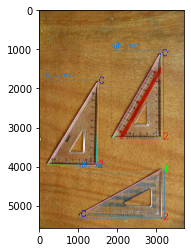

In [23]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

In [25]:
cv2.imwrite('output_H4.jpg', img_bgr)

True